# Prey-Predator simulation in cadCad

Author: Danilo Lessa Bernardineli (danilo.lessa@gmail.com)

This is an cadCAD agent-based simulation of the Lotka-Volterra prey-predator model on an 2D grid

Inspired by the model on: http://shodor.org/~aweeden/predator-prey/

## Dependences

In [0]:
%%capture
!pip install cadcad

In [0]:
import pandas as pd
import random
import uuid
import matplotlib.pyplot as plt
import numpy as np
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

## Definitions

In [0]:
N = 20
M = 15
initial_sites = np.ones((N, M)) * 5
locations = [(n, m) for n in range(N) for m in range(M)]

n_predators = 10
n_preys = 100

initial_agents = []

for i in range(n_preys):
  location = random.choice(locations)
  locations.remove(location)
  agent = {'uuid': uuid.uuid4(),
              'type': 'prey',
              'location': location,
              'food': 10,
              'age': 0}
  initial_agents.append(agent)

for i in range(n_predators):
  location = random.choice(locations)
  locations.remove(location)
  agent = {'uuid': uuid.uuid4(),
              'type': 'predator',
              'location': location,
              'food': 10,
              'age': 0}
  initial_agents.append(agent)

In [4]:
{'uuid': uuid.uuid4(),
 'type': 'predator',
 'location': location,
 'food': 10,
 'age': 0}

{'age': 0,
 'food': 10,
 'location': (5, 9),
 'type': 'predator',
 'uuid': UUID('dd3a9dc0-c933-48b7-a9ca-bf7b8e58c6df')}

### Initial conditions and parameters

In [0]:
initial_conditions = {
    'sites': initial_sites, # [N, m, 1]
    'agents': initial_agents, #
    'food_growth_rate': 1,
    'maximum_food_per_site': 15,
    'reproduction_probability': 1.0,
    'maximum_age': 100,
    'minimum_food': 7,
    'hungry_threshold': 5,
    'reproduction_food': 2
}

simulation_parameters = {
    'T': range(400),
    'N': 1,
    'M': {}
}

### Policies

In [0]:
@np.vectorize
def augment_food(x, x_m, increment):
  if x < x_m:
    return x + increment
  else:
    return x



def regenerate_food(params, step, sL, s):
  """
  Increases the food supply in all sites, subject to an maximum.
  """
  sites = s['sites']
  x_m = s['maximum_food_per_site']
  increment = s['food_growth_rate']
  updated_sites = augment_food(sites, x_m, increment)
  return {'update_sites': updated_sites}


def feed_prey(params, step, sL, s):
  """
  Feeds the hungry prey with all food located on its site.
  """
  agents = s['agents']
  sites = s['sites']
  hungry_threshold = s['hungry_threshold']
  preys = [agent for agent in agents if agent['type'] == 'prey']
  hungry_preys = [prey for prey in preys
                  if prey['food'] < hungry_threshold]
  for hungry_prey in hungry_preys:
    location = hungry_prey['location']
    available_food = sites[location]
    hungry_prey['food'] += available_food
    sites[location] = 0
  return {'update_sites': sites,
          'update_agents': {'update': hungry_preys}}


def feed_predators(params, step, sL, s):  
  """
  Feeds the hungry predators with an random nearby prey.
  """
  agents = s['agents']
  sites = s['sites']
  hungry_threshold = s['hungry_threshold']
  preys = [agent for agent in agents if agent['type'] == 'prey']
  predators = [agent for agent in agents if agent['type'] == 'predator']
  hungry_predators = [predator for predator in predators
                      if predator['food'] < hungry_threshold]
  killed_preys = []
  for hungry_predator in hungry_predators:
    nearby_preys = nearby_agents(hungry_predator, preys)
    if len(nearby_preys) > 0:
      eaten_prey = random.choice(nearby_preys)
      hungry_predator['food'] += eaten_prey['food']
      killed_preys.append(eaten_prey)
      preys.remove(eaten_prey)

  return {'update_agents': {'update': hungry_predators,
                            'remove': killed_preys
                            }
          }


def check_location(agent, sites, agents):
  N, M = sites.shape
  site = agent["location"]
  potential_sites = [(site[0], site[1] + 1),
                     (site[0], site[1] - 1),
                     (site[0] + 1, site[1]),
                     (site[0] - 1, site[1])]
  potential_sites = [(site[0] % N, site[1] % M) for site in potential_sites]
  agents_sites = [agent["location"] for agent in agents]
  sites = [site for site in potential_sites if site not in agents_sites]
  return sites

def get_free_location(agent, sites, agents):
  available_locations = check_location(agent, sites, agents)
  if len(available_locations) > 0:
    return random.choice(available_locations)
  else:
    return False


def is_neighbor(location_1, location_2):
  dx = np.abs(location_1[0] - location_2[0])
  dy = (location_1[1] - location_2[0])
  distance = dx + dy
  if distance == 1:
    return True
  else:
    return False


def nearby_agents(agent, agents):
  neighbors = [other_agent for other_agent in agents
               if is_neighbor(other_agent['location'], agent['location']) is True]
  return neighbors


def reproduce_agents(params, step, sL, s):
  """
  Generates an new agent through an nearby agent pair, subject to rules.
  Not done.
  """
  agents = s['agents']
  sites = s['sites']
  minimum_food = s['minimum_food']
  reproduction_probability = s['reproduction_probability']
  reproduction_food = 2
  already_reproduced = []
  new_agents = []
  reproduced_agents = []

  for agent_type in set(agent['type'] for agent in agents):
    specific_agents = [agent for agent in agents
                       if agent['type'] == agent_type]
    for agent in specific_agents:
      kind_neighbors = nearby_agents(agent, specific_agents)
      available_partners = [agent for agent in kind_neighbors 
                            if ((agent['food'] > minimum_food)
                                & (agent['uuid'] not in already_reproduced)
                               )
                            ]

      reproduction_location = get_free_location(agent, sites, agents)
      reproduction_condition = (len(available_partners) > 0)
      reproduction_condition &= reproduction_location is not False
      #reproduction_condition &= (agent['food'] > minimum_food)
      reproduction_condition &= ~(agent['uuid'] in already_reproduced)
      #reproduction_condition &= (reproduction_probability <= random.random())
      if reproduction_condition != 0:
        reproduction_partner = random.choice(available_partners)
        already_reproduced.append(reproduction_partner['uuid'])
        already_reproduced.append(agent['uuid'])
        reproduction_partner['food'] -= reproduction_food
        agent['food'] -= reproduction_food
        reproduced_agents.append(reproduction_partner)
        reproduced_agents.append(agent)
        new_agent = {'uuid': uuid.uuid4(),
                     'type': agent_type,
                     'location': reproduction_location,
                     'food': 2 * reproduction_food,
                     'age': 0}
        new_agents.append(new_agent)
        # create new agent
        # transfer food
  return {'update_agents': {'update': reproduced_agents,
                            'add': new_agents}}


def move_agents(params, step, sL, s):
  """
  Move agents.
  """
  sites = s['sites']
  agents = s['agents']
  for agent in agents:
    new_location = get_free_location(agent, sites, agents)
    if new_location is not False:
      agent['location'] = new_location

  return {'update_agents': {'update': agents}}


def age_agents(params, step, sL, s):
  """
  Time effects.
  """
  agents = s['agents']
  for agent in agents:
    agent['age'] += 1  
    agent['food'] -= 1
  return {'update_agents': {'update': agents}}


def kill_agents(params, step, sL, s):
  agents = s['agents']
  maximum_age = s['maximum_age']
  killed_agents = []
  for agent in agents:
    to_kill = agent['age'] > maximum_age
    to_kill |= agent['food'] <= 0
    if to_kill:
      killed_agents.append(agent)
  return {'update_agents': {'remove': killed_agents}}

### State update functions

In [0]:
def update_agents(params, step, sL, s, _input):
  y = 'agents'
  x = s['agents']

  data = _input.get("update_agents", {})
  removed_agents = data.get("remove", [])
  removed_uuids = [agent['uuid'] for agent in removed_agents]
  updated_agents = data.get("update", [])
  updated_uuids = [agent["uuid"] for agent in updated_agents]
  added_agents = data.get("add", [])

  for agent in x:
    uuid = agent["uuid"]
    if uuid in removed_uuids:
      x.remove(agent)
    elif uuid in updated_uuids:
      updated_agent = [agent for agent in updated_agents
                       if agent["uuid"] == uuid][0]
      x.remove(agent)
      x.append(updated_agent)

  for agent in added_agents:
    x.append(agent)
  
  return (y, x)


def update_sites(params, step, sL, s, _input):
  y = 'sites'
  x = _input['update_sites']
  return (y, x)

### State update blocks

In [0]:
partial_state_update_blocks = [
    { 
        'policies': {
            'regenerate_food': regenerate_food
        },
        'variables': {
            'sites': update_sites
        }
    },
    {
        'policies': {

            'feed_predators': feed_predators
        },
        'variables': {
            'agents': update_agents
        }
    },
    {
        'policies': {       
            'feed_prey': feed_prey
        },
        'variables': {
            'agents': update_agents
        }
    },
    {
        'policies': {       
            'reproduce_agents': reproduce_agents
        },
        'variables': {
            'agents': update_agents
        }
    },
    {
        'policies': {
            'move_agents': move_agents
        },
        'variables': {
            'agents': update_agents
        }
    },
    {
        'policies': {
            'ageing': age_agents
        },
        'variables': {
            'agents': update_agents
        }
    },
    {
        'policies': {
            'natural_death': kill_agents
        },
        'variables': {
            'agents': update_agents
        }
    }
]


### Configuration and Execution

In [9]:
config = Configuration(initial_state=initial_conditions, 
                       partial_state_update_blocks=partial_state_update_blocks, 
                       sim_config=simulation_parameters 
                      )

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) 
raw_result, tensor = executor.execute() 


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: single_proc: [<cadCAD.configuration.Configuration object at 0x7fef9b4a2390>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7fef9b4a2390>]


In [0]:
result = [el for el in raw_result if el['substep'] == 1]

In [0]:
result_agents = [el['agents'] for el in result]

prey_count = []
pred_count = []
for agents in result_agents:
  prey = [agent for agent in agents if agent['type'] == 'prey']
  prey_count.append(len(prey))
  pred = [agent for agent in agents if agent['type'] == 'predator']
  pred_count.append(len(pred))

In [0]:
def norm(x):
  return np.array(x) / np.max(x)

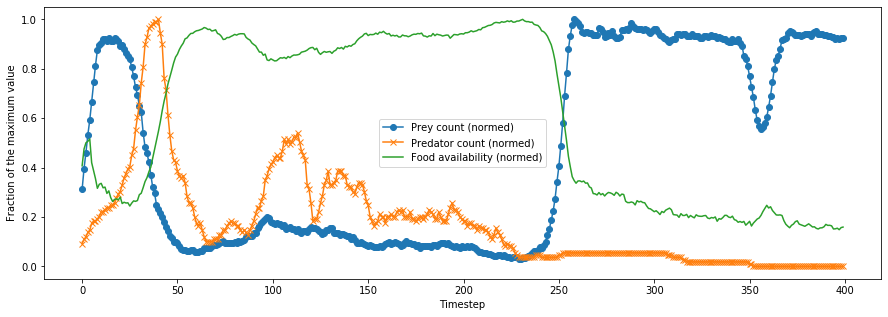

In [13]:
available_food = np.array([np.sum(el['sites']) for el in result])
plt.figure(figsize=(15, 5))
plt.plot(norm(prey_count), 'o-', label='Prey count (normed)')
plt.plot(norm(pred_count), 'x-', label='Predator count (normed)')
plt.plot(norm(available_food), '-', label='Food availability (normed)')
plt.ylabel("Fraction of the maximum value")
plt.xlabel("Timestep")
plt.legend()
plt.show()

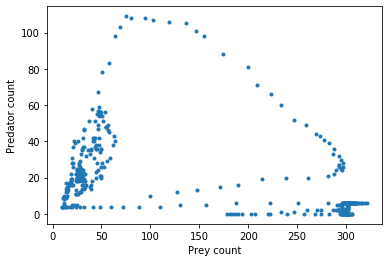

In [14]:
plt.xlabel("Prey count")
plt.ylabel("Predator count")
plt.plot(prey_count, pred_count, '.')